# Validating degradation rates with metabolic labeling data



Battich et al. (https://www.science.org/doi/10.1126/science.aax3072?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed) used a pulse/chase labeling experiment to obtain rates of decay and synthesis for genes in human retinal pigment epithelial (rpe1) cells. The first author provided us with degradation rates normalized over cell cycle. 

This notebook fits $biVI$ to their data, assuming a steady-state model, and we compare the biVI inferred relative degradation rates to the average rates reported by Battich. 


Here, $\gamma$ is the symbol Battich uses for degradation. 

In [3]:
# System
import sys
sys.path.insert(0, '../BIVI')


# necessary packages 
import numpy as np
import torch
import pandas as pd
import pickle
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns

# colors
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
matplotlib.rc('xtick', labelsize=22) 
matplotlib.rc('ytick', labelsize=22) 

# single cell
import anndata
import scanpy as sc

# import biVI scripts
import biVI


def nd(matrix):
    return(np.array(matrix).flatten())

Global seed set to 0
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [7]:
# rpe marker genes from 
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8718768/
rpe_MG = [
'GAPDH',
'PAX6',
'BEST1',
'ID3',
'CTGF',
'FST',
'KCNMA1',
'PRPF31',
'TIMP3',
'RETSAT', 
'RDH11',
'RDH13']


In [8]:
# load in rpe data
path_to_rpe = './data/battich/rpe1.h5ad'
path_to_battich_gamma = './data/battich/Battich_RPE1_Gammas.csv'

# load in rpe
rpe = anndata.read_h5ad(path_to_rpe)

# add gene names
gene_names_df = pd.read_csv('./data/battich/rpe_gene_names.csv').dropna()
gene_names = gene_names_df['gene_name'].tolist()
gene_ids = gene_names_df['gene_id'].tolist()

rpe = rpe[:,gene_ids]
rpe.var['gene_name'] = gene_names

# subet to genes
rpe.layers['unspliced'] = rpe.layers['ul'] + rpe.layers['uu']
rpe.layers['spliced'] = rpe.layers['sl'] + rpe.layers['su']

U_min = 0.01
S_min = 0.01


filt = nd(rpe.layers['unspliced'].mean(axis=0) > U_min) & nd(rpe.layers['spliced'].mean(axis=0) > S_min).flatten()
gene_names_to_keep = list(rpe.var['gene_name'].values.flatten()[filt]) + rpe_MG

# gene_names_to_keep = monod_genes + rpe_MG
# filter based on marker genes
rpe_subset = rpe[:,rpe.var['gene_name'].isin(gene_names_to_keep)]

<ipython-input-8-bd2789c16dc6>:14: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  rpe.var['gene_name'] = gene_names


In [9]:
rpe_subset

View of AnnData object with n_obs × n_vars = 5422 × 8312
    obs: 'Plate_Id', 'Condition_Id', 'Well_Id', 'RFP_log10_corrected', 'GFP_log10_corrected', 'Cell_cycle_possition', 'Cell_cycle_relativePos', 'exp_type', 'time'
    var: 'Gene_Id', 'gene_name'
    layers: 'sl', 'su', 'ul', 'uu', 'unspliced', 'spliced'

In [10]:
# load in battich degradation rates
battich_gamma = pd.read_csv(path_to_battich_gamma,skiprows=1)

# filter for genes that had a certain threshold for unspliced means and certain threshold for spliced means
battich_gamma_index = [g in rpe_subset.var['gene_name'].values for g in battich_gamma['gene_name'].values] 
battich_gamma_subset = battich_gamma[battich_gamma_index]


filt2 = [g in battich_gamma['gene_name'].values for g in rpe_subset.var['gene_name'].values] 
rpe_subset = rpe_subset[:,filt2]


In [13]:
len(battich_gamma)

6086

In [15]:
for c in rpe_subset.obs['Condition_Id'].unique():
    
    print(c,len(rpe_subset[rpe_subset.obs['Condition_Id'] == c]))
    
    

Chase_360 334
Chase_120 541
Chase_60 436
Chase_0 460
Chase_dmso 202
Chase_240 391
Pulse_15 442
Pulse_30 574
Pulse_45 564
Pulse_60 405
Pulse_120 408
Pulse_180 400
Pulse_dmso 265


In [6]:
# get dataset ready for inference! that is, concatenate spliced and unspliced layers
rpe_old = rpe_subset
rpe_spliced   = anndata.AnnData(rpe_subset.layers['spliced'])
rpe_unspliced = anndata.AnnData(rpe_subset.layers['unspliced'])

rpe_spliced.var = rpe_subset.var.copy()
rpe_unspliced.var = rpe_subset.var.copy()
rpe_spliced.var['Spliced']   = True
rpe_unspliced.var['Spliced'] = False
rpe_unspliced.var_names = rpe_unspliced.var_names + '-u'

## Change AnnData expression to raw counts for negative binomial distribution
rpe_new = anndata.concat([rpe_unspliced,rpe_spliced],axis=1)
rpe_new.layers["counts"] = rpe_new.X.copy() # preserve counts

# Update obs,var
rpe_new.obs = rpe_old.obs.copy()

<ipython-input-6-7db14c102573>:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  rpe_spliced   = anndata.AnnData(rpe_subset.layers['spliced'])
<ipython-input-6-7db14c102573>:4: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  rpe_unspliced = anndata.AnnData(rpe_subset.layers['unspliced'])


In [7]:
# Fit for one condition : Say, CHASE_0 
rpe_dmso = rpe_new[rpe_new.obs.Condition_Id == 'Chase_dmso'].copy()
# set up anndata with biVI, specifying training layer
biVI.biVI.setup_anndata(rpe_dmso,layer="counts")

In [8]:
model_args = {    'n_latent'     : 10,
                  'n_layers'     : 3,
                  'dispersion'   : 'gene',
                  'n_hidden'     : 128,
                  'dropout_rate' :  0.1,
                  'log_variational'    :  True,
                  'latent_distribution':  'normal',
                  'THETA_IS' : 'NAS_SHAPE'
                  }

# training plan parameters
max_epochs = 400

plan_kwargs = {'lr' : 0.001,
               'n_epochs_kl_warmup' : max_epochs/2,
                }

In [9]:
model = biVI.biVI(rpe_dmso,mode='Bursty',**model_args)

{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Bursty, Decoder: non-linear, Theta is: NAS_SHAPE


In [10]:
rpe_dmso

AnnData object with n_obs × n_vars = 202 × 10612
    obs: 'Plate_Id', 'Condition_Id', 'Well_Id', 'RFP_log10_corrected', 'GFP_log10_corrected', 'Cell_cycle_possition', 'Cell_cycle_relativePos', 'exp_type', 'time', '_scvi_batch', '_scvi_labels'
    var: 'Gene_Id', 'gene_name', 'Spliced'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    layers: 'counts'

In [11]:
model.train(max_epochs = 3,
                train_size = 0.9,
                check_val_every_n_epoch  = 1,
                plan_kwargs = plan_kwargs)

/home/tara/.local/lib/python3.8/site-packages/scvi/model/base/_training_mixin.py:60: UserWarning: max_epochs=3 is less than n_epochs_kl_warmup=200.0. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 3/3: 100%|██████████| 3/3 [00:01<00:00,  2.46it/s, loss=1.36e+04, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s, loss=1.36e+04, v_num=1]


# Get biVI parameters

In [ ]:
# get parameters
parameters = model.get_likelihood_parameters()

In [ ]:
betas_biVI = parameters['rel_splicing_rate']
betas_biVI_avg = betas_biVI.mean(axis=0)
gammas_biVI = parameters['rel_degradation_rate']
gammas_biVI_avg = gammas_biVI.mean(axis=0)
bs_biVI = parameters['burst_size']
bs_biVI_avg = betas_biVI.mean(axis=0)

In [ ]:
gammas_biVI_subset = pd.DataFrame({'gene_name' : rpe_dmso.var['gene_name'].values[:int(len(rpe_dmso.var['gene_name'].values)/2)],
                                'rel_degradation_rate' : gammas_biVI_avg })

# gammas_biVI_index = [g in rpe_MG for g in gammas_biVI_df['gene_name'].values] 
# gammas_biVI_subset = gammas_biVI_df[gammas_biVI_index]
# battich_index = [g in rpe_MG for g in battich_gamma_subset['gene_name'].values] 
# battich_gamma_subset = battich_gamma_subset[battich_index]

In [ ]:
gammas_biVI_subset = gammas_biVI_subset.sort_values(by='gene_name')
battich_gamma_subset = battich_gamma_subset.sort_values(by='gene_name')

In [ ]:
sum(gammas_biVI_subset['gene_name'].values == battich_gamma_subset['gene_name'].values)

In [ ]:
plt.scatter(gammas_biVI_subset['rel_degradation_rate'].values,battich_gamma_subset['degradation_rate_Battich_2020_RPE1'].values,s=2)
correlation_,p = pearsonr(np.log(gammas_biVI_subset['rel_degradation_rate'].values),
                          np.log(battich_gamma_subset['degradation_rate_Battich_2020_RPE1'].values))
plt.xlabel('Relative degradation rate, biVI inferred')
# plt.ylabel('Reported average degradation rate')
plt.title(f'RPE1 cells from Battich paper, R: {correlation_:.3f}',fontsize=fs,color=colors[i])
plt.xscale('log')
plt.yscale('log')

# Restrict to marker genes and see what that looks like

In [ ]:
gammas_biVI_index = [g in rpe_MG for g in gammas_biVI_df['gene_name'].values] 
gammas_biVI_subset = gammas_biVI_df[gammas_biVI_index]
battich_index = [g in rpe_MG for g in battich_gamma_subset['gene_name'].values] 
battich_gamma_subset = battich_gamma_subset[battich_index]
gammas_biVI_subset = gammas_biVI_subset.sort_values(by='gene_name')
battich_gamma_subset = battich_gamma_subset.sort_values(by='gene_name')

In [ ]:
plt.scatter(gammas_biVI_subset['rel_degradation_rate'].values,battich_gamma_subset['degradation_rate_Battich_2020_RPE1'].values,s=2)
correlation_,p = pearsonr(np.log(gammas_biVI_subset['rel_degradation_rate'].values),
                          np.log(battich_gamma_subset['degradation_rate_Battich_2020_RPE1'].values))
plt.xlabel('Relative degradation rate, biVI inferred')
plt.ylabel('Reported average degradation rate',fontsize=14)
plt.title(f'Marker genes for RPE1 cells, R: {correlation_:.3f}')
plt.xscale('log')
plt.yscale('log')

# Fit ALL Chase conditions to Bursty model


In [15]:
# Fit for ALL conditions
fs = 16

colors = sns.color_palette("Set2")[1:] + sns.color_palette("tab10")

torch.cuda.empty_cache()   
for i,c in enumerate(rpe_new.obs.Condition_Id.unique()[1:]):
    print(c)
    rpe_ = rpe_new[rpe_new.obs.Condition_Id == c].copy()
    # set up anndata with biVI, specifying training layer
    biVI.biVI.setup_anndata(rpe_,layer="counts")
    
    model = biVI.biVI(rpe_,mode='Bursty',**model_args)
    
    model.train(max_epochs = max_epochs,
                train_size = 0.9,
                check_val_every_n_epoch  = 1,
                plan_kwargs = plan_kwargs)
    
    # get parameters
    parameters = model.get_likelihood_parameters()
    gammas_biVI = parameters['rel_degradation_rate']
    gammas_biVI_avg = gammas_biVI.mean(axis=0)
    
    parameters['gene_name'] = rpe_.var['gene_name']
    parameters['gene_id'] = rpe_.var['Gene_Id']
    
    for key in model.history.keys():
        parameters[key] = model.history[key]
    with open(f'../results/biVI_Bursty_parameters_{c}','wb') as file:
        pickle.dump(parameters,file,protocol=pickle.HIGHEST_PROTOCOL)
#     gammas_biVI_subset = pd.DataFrame({'gene_name' : rpe_.var['gene_name'].values[:int(len(rpe_.var['gene_name'].values)/2)],
#                                 'rel_degradation_rate' : gammas_biVI_avg })
#     gammas_biVI_subset = gammas_biVI_subset.sort_values(by='gene_name')
#     battich_gamma_subset = battich_gamma_subset.sort_values(by='gene_name')
#     assert(all(gammas_biVI_subset['gene_name'].values == battich_gamma_subset['gene_name'].values))                                      
#     plt.scatter(gammas_biVI_subset['rel_degradation_rate'].values,
#                 battich_gamma_subset['degradation_rate_Battich_2020_RPE1'].values,
#                 s=2,color=colors[i],alpha=0.7)
#     correlation_,p = pearsonr(np.log(gammas_biVI_subset['rel_degradation_rate'].values),
#                           np.log(battich_gamma_subset['degradation_rate_Battich_2020_RPE1'].values))
#     plt.xlabel('log10 avg $\gamma / k$, biVI',fontsize=fs)
#     plt.ylabel('log10 avg $\gamma$, Battich reported',fontsize=fs)
                                     
#     plt.title(f'biVI Bursty model, {c} R: {correlation_:.3f}',fontsize=fs+2)
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.grid(color='lightgray')
#     plt.show()
    torch.cuda.empty_cache()                                 
                                     
    

Chase_120
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Bursty, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [04:11<00:00,  1.61it/s, loss=8.55e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [04:11<00:00,  1.59it/s, loss=8.55e+03, v_num=1]
Bursty mode, getting parameters
Chase_60
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Bursty, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [03:31<00:00,  1.91it/s, loss=8.82e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [03:31<00:00,  1.89it/s, loss=8.82e+03, v_num=1]
Bursty mode, getting parameters
Chase_0
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Bursty, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [03:38<00:00,  1.86it/s, loss=9.32e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [03:38<00:00,  1.83it/s, loss=9.32e+03, v_num=1]
Bursty mode, getting parameters
Chase_dmso
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Bursty, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [01:39<00:00,  4.09it/s, loss=7.66e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:39<00:00,  4.03it/s, loss=7.66e+03, v_num=1]
Bursty mode, getting parameters
Chase_240
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Bursty, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [03:04<00:00,  2.20it/s, loss=8.72e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [03:04<00:00,  2.17it/s, loss=8.72e+03, v_num=1]
Bursty mode, getting parameters
Pulse_15
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Bursty, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [03:31<00:00,  1.91it/s, loss=7.58e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [03:31<00:00,  1.89it/s, loss=7.58e+03, v_num=1]
Bursty mode, getting parameters
Pulse_30
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Bursty, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [04:34<00:00,  1.48it/s, loss=8.38e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [04:34<00:00,  1.46it/s, loss=8.38e+03, v_num=1]
Bursty mode, getting parameters
Pulse_45
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Bursty, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [04:20<00:00,  1.56it/s, loss=7.91e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [04:20<00:00,  1.53it/s, loss=7.91e+03, v_num=1]
Bursty mode, getting parameters
Pulse_60
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Bursty, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [03:08<00:00,  2.16it/s, loss=7.71e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [03:08<00:00,  2.12it/s, loss=7.71e+03, v_num=1]
Bursty mode, getting parameters
Pulse_120
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Bursty, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [03:09<00:00,  2.14it/s, loss=7.85e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [03:09<00:00,  2.11it/s, loss=7.85e+03, v_num=1]
Bursty mode, getting parameters
Pulse_180
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Bursty, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [03:06<00:00,  2.17it/s, loss=7.98e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [03:06<00:00,  2.15it/s, loss=7.98e+03, v_num=1]
Bursty mode, getting parameters
Pulse_dmso
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Bursty, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [02:05<00:00,  3.20it/s, loss=7.26e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:05<00:00,  3.19it/s, loss=7.26e+03, v_num=1]
Bursty mode, getting parameters


# Fit ALL Chase conditions to Constitutive model

In [16]:


for i,c in enumerate(rpe_new.obs.Condition_Id.unique()[1:]):
    print(c)
    rpe_ = rpe_new[rpe_new.obs.Condition_Id == c].copy()
    # set up anndata with biVI, specifying training layer
    biVI.biVI.setup_anndata(rpe_,layer="counts")
    
    model = biVI.biVI(rpe_,mode='Poisson',**model_args)
    
    model.train(max_epochs = max_epochs,
                train_size = 0.9,
                check_val_every_n_epoch  = 1,
                plan_kwargs = plan_kwargs)
    
    # get parameters
    parameters = model.get_likelihood_parameters()
    gammas_biVI = parameters['rel_degradation_rate']
    gammas_biVI_avg = gammas_biVI.mean(axis=0)
    
    parameters['gene_name'] = rpe_.var['gene_name']
    parameters['gene_id'] = rpe_.var['Gene_Id']
    
    for key in model.history.keys():
        parameters[key] = model.history[key]
    with open(f'../results/biVI_Constitutive_parameters_{c}','wb') as file:
        pickle.dump(parameters,file,protocol=pickle.HIGHEST_PROTOCOL)
    torch.cuda.empty_cache()    

Chase_120
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Poisson, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [00:30<00:00, 12.93it/s, loss=8.74e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:30<00:00, 13.25it/s, loss=8.74e+03, v_num=1]
Constitutive mode, getting parameters
Chase_60
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Poisson, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [00:28<00:00, 14.92it/s, loss=9.28e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:28<00:00, 14.18it/s, loss=9.28e+03, v_num=1]
Constitutive mode, getting parameters
Chase_0
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Poisson, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [00:28<00:00, 14.76it/s, loss=9.53e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:28<00:00, 14.14it/s, loss=9.53e+03, v_num=1]
Constitutive mode, getting parameters
Chase_dmso
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Poisson, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [00:16<00:00, 23.67it/s, loss=7.9e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:16<00:00, 24.17it/s, loss=7.9e+03, v_num=1]
Constitutive mode, getting parameters
Chase_240
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Poisson, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [00:22<00:00, 19.19it/s, loss=9.03e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:22<00:00, 17.81it/s, loss=9.03e+03, v_num=1]
Constitutive mode, getting parameters
Pulse_15
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Poisson, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [00:27<00:00, 13.73it/s, loss=7.88e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:27<00:00, 14.48it/s, loss=7.88e+03, v_num=1]
Constitutive mode, getting parameters
Pulse_30
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Poisson, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [00:33<00:00, 11.88it/s, loss=8.22e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:33<00:00, 12.01it/s, loss=8.22e+03, v_num=1]
Constitutive mode, getting parameters
Pulse_45
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Poisson, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [00:29<00:00, 13.95it/s, loss=8.19e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:29<00:00, 13.63it/s, loss=8.19e+03, v_num=1]
Constitutive mode, getting parameters
Pulse_60
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Poisson, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [00:21<00:00, 19.25it/s, loss=8.19e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:21<00:00, 18.23it/s, loss=8.19e+03, v_num=1]
Constitutive mode, getting parameters
Pulse_120
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Poisson, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [00:21<00:00, 19.19it/s, loss=8.19e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:21<00:00, 18.79it/s, loss=8.19e+03, v_num=1]
Constitutive mode, getting parameters
Pulse_180
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Poisson, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [00:21<00:00, 19.46it/s, loss=8.34e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:21<00:00, 18.44it/s, loss=8.34e+03, v_num=1]
Constitutive mode, getting parameters
Pulse_dmso
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: Poisson, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [00:17<00:00, 22.77it/s, loss=7.7e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:17<00:00, 22.96it/s, loss=7.7e+03, v_num=1]
Constitutive mode, getting parameters


# Fit ALL Chase conditions to Extrinsic model

In [17]:
for i,c in enumerate(rpe_new.obs.Condition_Id.unique()[1:]):
    print(c)
    rpe_ = rpe_new[rpe_new.obs.Condition_Id == c].copy()
    # set up anndata with biVI, specifying training layer
    biVI.biVI.setup_anndata(rpe_,layer="counts")
    
    model = biVI.biVI(rpe_,mode='NBcorr',**model_args)
    
    model.train(max_epochs = max_epochs,
                train_size = 0.9,
                check_val_every_n_epoch  = 1,
                plan_kwargs = plan_kwargs)
    
    # get parameters
    parameters = model.get_likelihood_parameters()
    gammas_biVI = parameters['rel_degradation_rate']
    gammas_biVI_avg = gammas_biVI.mean(axis=0)
    
    parameters['gene_name'] = rpe_.var['gene_name']
    parameters['gene_id'] = rpe_.var['Gene_Id']
    
    for key in model.history.keys():
        parameters[key] = model.history[key]
    with open(f'../results/biVI_Extrinsic_parameters_{c}','wb') as file:
        pickle.dump(parameters,file,protocol=pickle.HIGHEST_PROTOCOL)
    torch.cuda.empty_cache()   

Chase_120
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: NBcorr, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [00:30<00:00, 12.47it/s, loss=8.77e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:30<00:00, 13.05it/s, loss=8.77e+03, v_num=1]
Extrinsic mode, getting parameters
Chase_60
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: NBcorr, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [00:30<00:00, 12.97it/s, loss=8.92e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:30<00:00, 13.15it/s, loss=8.92e+03, v_num=1]
Extrinsic mode, getting parameters
Chase_0
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: NBcorr, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [00:30<00:00, 12.69it/s, loss=9.53e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:30<00:00, 13.10it/s, loss=9.53e+03, v_num=1]
Extrinsic mode, getting parameters
Chase_dmso
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: NBcorr, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [00:17<00:00, 20.42it/s, loss=7.98e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:17<00:00, 22.48it/s, loss=7.98e+03, v_num=1]
Extrinsic mode, getting parameters
Chase_240
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: NBcorr, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [00:23<00:00, 17.54it/s, loss=9.16e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:23<00:00, 16.90it/s, loss=9.16e+03, v_num=1]
Extrinsic mode, getting parameters
Pulse_15
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: NBcorr, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [00:27<00:00, 14.19it/s, loss=7.66e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:27<00:00, 14.51it/s, loss=7.66e+03, v_num=1]
Extrinsic mode, getting parameters
Pulse_30
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: NBcorr, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [00:36<00:00, 11.18it/s, loss=8.32e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:36<00:00, 11.08it/s, loss=8.32e+03, v_num=1]
Extrinsic mode, getting parameters
Pulse_45
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: NBcorr, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [00:30<00:00, 13.66it/s, loss=7.98e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:30<00:00, 13.33it/s, loss=7.98e+03, v_num=1]
Extrinsic mode, getting parameters
Pulse_60
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: NBcorr, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [00:23<00:00, 18.18it/s, loss=7.81e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:23<00:00, 17.04it/s, loss=7.81e+03, v_num=1]
Extrinsic mode, getting parameters
Pulse_120
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: NBcorr, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [00:23<00:00, 17.14it/s, loss=7.99e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:23<00:00, 17.33it/s, loss=7.99e+03, v_num=1]
Extrinsic mode, getting parameters
Pulse_180
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: NBcorr, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [00:23<00:00, 15.17it/s, loss=8.11e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:23<00:00, 16.93it/s, loss=8.11e+03, v_num=1]
Extrinsic mode, getting parameters
Pulse_dmso
{'n_input': 10612, 'n_hidden': 128, 'n_latent': 10, 'n_layers': 3, 'dropout_rate': 0.1, 'dispersion': 'gene', 'latent_distribution': 'normal', 'log_variational': True}
Initiating biVAE
Mode: NBcorr, Decoder: non-linear, Theta is: NAS_SHAPE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/tara/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [00:18<00:00, 22.20it/s, loss=7.52e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:18<00:00, 21.82it/s, loss=7.52e+03, v_num=1]
Extrinsic mode, getting parameters


# Plotting degradation rate correlations

Load in saved parameters and plot correlations between inferred relative degradation rates and Battich reported degradation rates.

In [29]:
# darker color pallette 
colors = sns.color_palette("Set2") + sns.color_palette("tab10")
original_palette = colors

# Define a function to make colors darker
def make_colors_darker(palette, factor):
    new_palette = []
    for color in palette:
        r, g, b = color
        # Decrease the brightness (lightness) of each color
        r = max(0, r - factor)
        g = max(0, g - factor)
        b = max(0, b - factor)
        new_palette.append((r, g, b))
    return new_palette

# Adjust the factor to control the darkness level (smaller values make it darker)
dark_factor = 0.2

# Create the darker palette
darker_palette = make_colors_darker(original_palette, dark_factor)
even_darker_palette = make_colors_darker(original_palette, dark_factor+0.2)

In [60]:
with open(f'../results/biVI_Bursty_parameters_Chase_0','rb') as file:
        chase_0_bursty = pickle.load(file)

In [41]:
subset_genes = chase_0_bursty['gene_name'][:int(len(chase_0_bursty['gene_name'])/2)].values

In [63]:
chase_0_bursty['reconstruction_loss_train']['reconstruction_loss_train'].values[-1]

9276.1484375

In [64]:
chase_0_bursty['reconstruction_loss_validation']['reconstruction_loss_validation'].values[-1]

9517.939453125

In [42]:
# load in battich degradation rates
path_to_battich_gamma = '../data/battich/Battich_RPE1_Gammas.csv'
battich_gamma = pd.read_csv(path_to_battich_gamma,skiprows=1)

# filter for genes that had a certain threshold for unspliced means and certain threshold for spliced means
battich_gamma_index = [g in subset_genes for g in battich_gamma['gene_name'].values] 
battich_gamma_subset = battich_gamma[battich_gamma_index]


In [43]:
conditions = ['Chase_0','Chase_60','Chase_120','Chase_240','Chase_dmso',]
#              'Pulse_15','Pulse_30','Pulse_45','Pulse_60','Pulse_120','Pulse_180','Pulse_dmso']

Chase_0


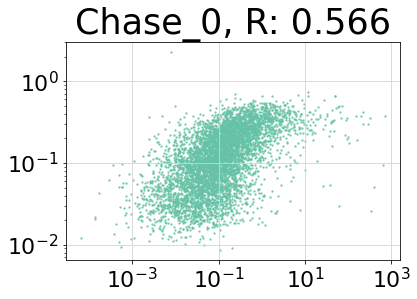

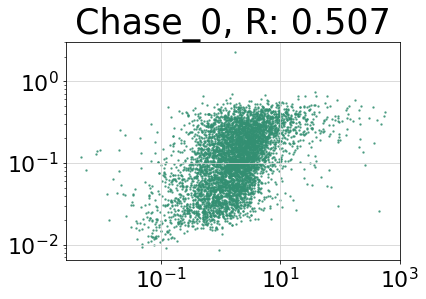

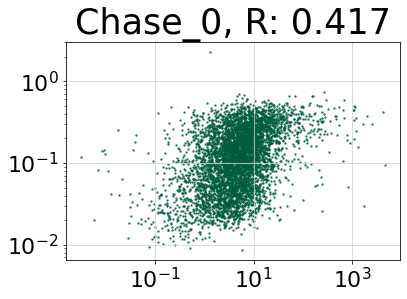

Chase_60


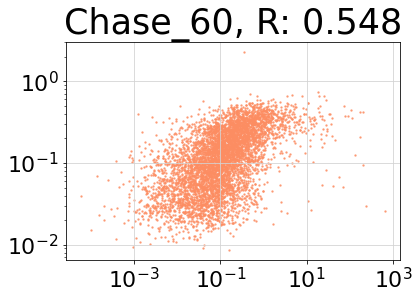

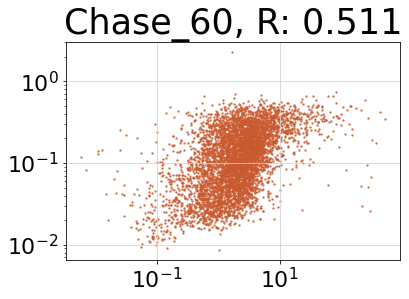

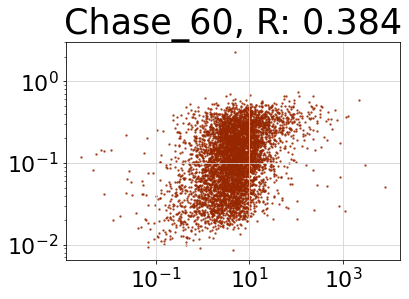

Chase_120


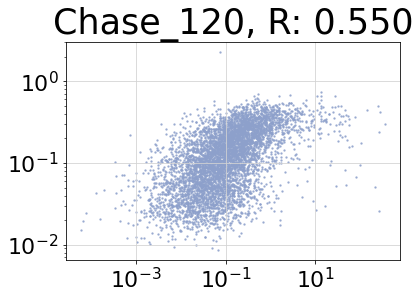

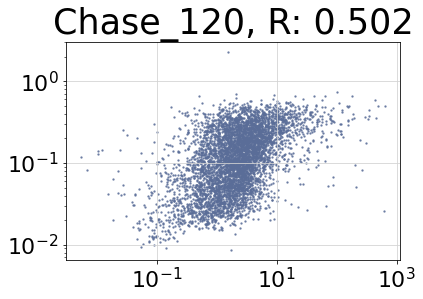

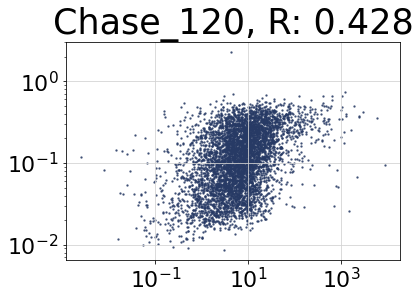

Chase_240


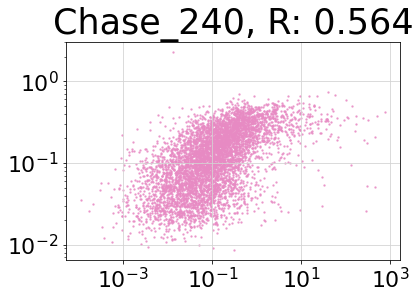

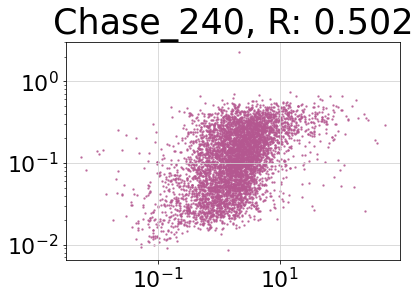

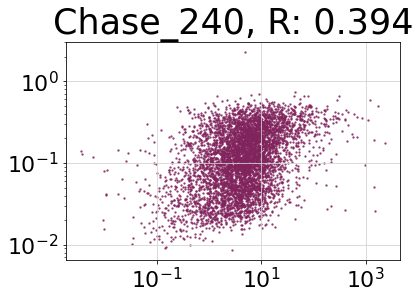

Chase_dmso


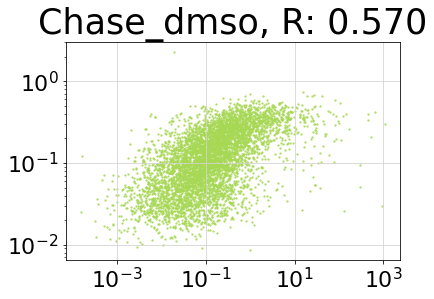

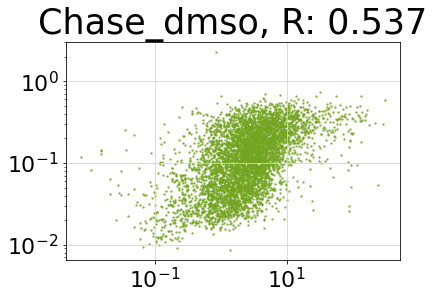

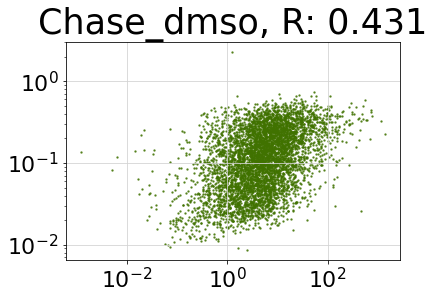

In [65]:
correlations = []
plot_conditions = []
train_recon_loss = []
valid_recon_loss = []
# colors = sns.color_palette("Paired", 12)

fs = 35
for i,c in enumerate(conditions):
    print(c)
    with open(f'../results/biVI_Bursty_parameters_{c}','rb') as file:
        params_ = pickle.load(file)
    
    
    gammas_biVI_subset = pd.DataFrame({'gene_name' : subset_genes,
                                       'rel_degradation_rate' : params_['rel_degradation_rate'].mean(axis=0)})

    gammas_biVI_subset = gammas_biVI_subset.sort_values(by='gene_name')
    battich_gamma_subset = battich_gamma_subset.sort_values(by='gene_name')
    correlation_,p = pearsonr(np.log(gammas_biVI_subset['rel_degradation_rate'].values),
                              np.log(battich_gamma_subset['degradation_rate_Battich_2020_RPE1'].values))
    correlations.append(correlation_)
    plot_conditions.append('Bursty')
    train_recon_loss.append(params_['reconstruction_loss_train']['reconstruction_loss_train'].values[-1])
    valid_recon_loss.append(params_['reconstruction_loss_validation']['reconstruction_loss_validation'].values[-1])
    
    # and plot!!
    plt.scatter(gammas_biVI_subset['rel_degradation_rate'].values,
                battich_gamma_subset['degradation_rate_Battich_2020_RPE1'].values,
                s=2,color=original_palette[i],alpha=0.7,
                )

    
    correlation_,p = pearsonr(np.log(gammas_biVI_subset['rel_degradation_rate'].values),
                          np.log(battich_gamma_subset['degradation_rate_Battich_2020_RPE1'].values))
                                     
    plt.title(f'{c}, R: {correlation_:.3f}',fontsize=fs)
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(color='lightgray')
    plt.show()
    
    with open(f'../results/biVI_Constitutive_parameters_{c}','rb') as file:
        params_ = pickle.load(file)
    
    
    gammas_biVI_subset = pd.DataFrame({'gene_name' : subset_genes,
                                'rel_degradation_rate' : params_['rel_degradation_rate'].mean(axis=0)})
    gammas_biVI_subset = gammas_biVI_subset.sort_values(by='gene_name')
    battich_gamma_subset = battich_gamma_subset.sort_values(by='gene_name')
    
    correlation_,p = pearsonr(np.log(gammas_biVI_subset['rel_degradation_rate'].values),
                              np.log(battich_gamma_subset['degradation_rate_Battich_2020_RPE1'].values))
    correlations.append(correlation_)
    plot_conditions.append('Constitutive')
    train_recon_loss.append(params_['reconstruction_loss_train']['reconstruction_loss_train'].values[-1])
    valid_recon_loss.append(params_['reconstruction_loss_validation']['reconstruction_loss_validation'].values[-1])
    
    # and plot!!
    plt.scatter(gammas_biVI_subset['rel_degradation_rate'].values,
                battich_gamma_subset['degradation_rate_Battich_2020_RPE1'].values,
                s=2,color=darker_palette[i],alpha=0.7,
                )
    correlation_,p = pearsonr(np.log(gammas_biVI_subset['rel_degradation_rate'].values),
                          np.log(battich_gamma_subset['degradation_rate_Battich_2020_RPE1'].values))
#     plt.xlabel('log10 avg $\gamma / k$, biVI',fontsize=fs)
#     plt.ylabel('log10 avg $\gamma$, Battich reported',fontsize=fs)
                                     
    plt.title(f'{c}, R: {correlation_:.3f}',fontsize=fs)
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(color='lightgray')
    plt.show()
    
    
    with open(f'../results/biVI_Extrinsic_parameters_{c}','rb') as file:
        params_ = pickle.load(file)
    
    
    gammas_biVI_subset = pd.DataFrame({'gene_name' : subset_genes,
                                'rel_degradation_rate' : params_['rel_degradation_rate'].mean(axis=0)})
    gammas_biVI_subset = gammas_biVI_subset.sort_values(by='gene_name')
    battich_gamma_subset = battich_gamma_subset.sort_values(by='gene_name')
    
    correlation_,p = pearsonr(np.log(gammas_biVI_subset['rel_degradation_rate'].values),
                              np.log(battich_gamma_subset['degradation_rate_Battich_2020_RPE1'].values))
    correlations.append(correlation_)
    
    plot_conditions.append('Extrinsic Noise')
    train_recon_loss.append(params_['reconstruction_loss_train']['reconstruction_loss_train'].values[-1])
    valid_recon_loss.append(params_['reconstruction_loss_validation']['reconstruction_loss_validation'].values[-1])
    
    # and plot!!
    plt.scatter(gammas_biVI_subset['rel_degradation_rate'].values,
                battich_gamma_subset['degradation_rate_Battich_2020_RPE1'].values,
                s=2,color=even_darker_palette[i],alpha=0.7,
                )
    correlation_,p = pearsonr(np.log(gammas_biVI_subset['rel_degradation_rate'].values),
                          np.log(battich_gamma_subset['degradation_rate_Battich_2020_RPE1'].values))
#     plt.xlabel('log10 avg $\gamma / k$, biVI',fontsize=fs)
#     plt.ylabel('log10 avg $\gamma$, Battich reported',fontsize=fs)
                                     
    plt.title(f'{c}, R: {correlation_:.3f}',fontsize=fs)
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(color='lightgray')
    plt.show()

In [111]:
df_plot = pd.DataFrame({'Model' : plot_conditions,
                        'Correlations' : correlations})

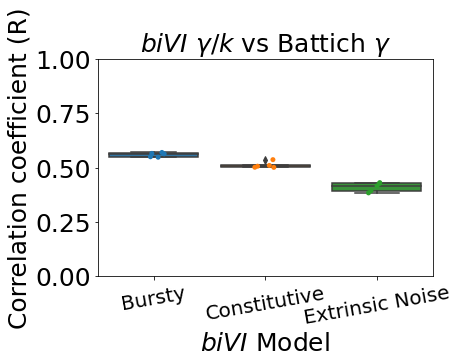

In [112]:
save_path = None
fs = 25


ax = sns.boxplot(data=df_plot, x="Model", y="Correlations")

sns.stripplot(data=df_plot, x="Model", y="Correlations",ax=ax)
plt.xlabel('$biVI$ Model',fontsize=fs)
plt.ylabel('Correlation coefficient (R)',fontsize=fs)
plt.title('$biVI$ $\gamma/k$ vs Battich $\gamma$',fontsize=fs)
plt.ylim(0.,1)
plt.xticks(fontsize=20,rotation=10)
plt.yticks(fontsize=25)

if save_path:
    plt.savefig(save_path,dpi=400,bbox_inches='tight')

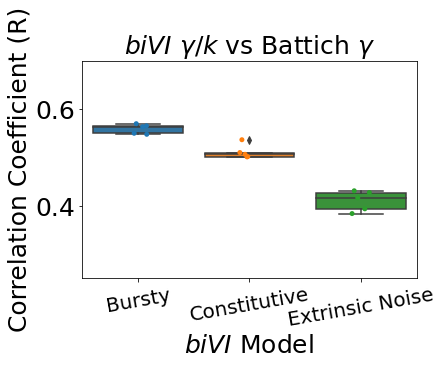

In [68]:
save_path = None
fs = 25


ax = sns.boxplot(data=df_plot, x="Model", y="Correlations")

sns.stripplot(data=df_plot, x="Model", y="Correlations",ax=ax)
plt.xlabel('$biVI$ Model',fontsize=fs)
plt.ylabel('Correlation Coefficient (R)',fontsize=fs)
plt.title('$biVI$ $\gamma/k$ vs Battich $\gamma$',fontsize=fs)
plt.ylim(0.,1)
plt.xticks(fontsize=20,rotation=10)
plt.yticks(fontsize=25)
plt.ylim(0.25,0.7)

if save_path:
    plt.savefig(save_path,dpi=400,bbox_inches='tight')

# Model selection: AIC 

Akaike information criteria is a derived from information theory to select a model which best represents data. It uses the likelihood of the data under the model and the number of parameters in the model. 

$$ AIC = 2k - 2ln(L) $$

Where k is the number of parameters in the model and L is the model likelihood.

In [95]:
def get_AIC(k,logL):
    '''logL is ln(L)'''
    return(2*k-2*logL)

In [96]:
logL = -np.array(train_recon_loss) +  (-np.array(train_recon_loss))

In [97]:
# bursty has 2*N_genes*N_cells + N_genes parameters
k_bursty = 2*params_['dispersions'].shape[0]*params_['dispersions'].shape[1] + params_['dispersions'].shape[1]

# constitutive has 2*N_genes*N_cells parameters
k_const = 2*params_['dispersions'].shape[0]*params_['dispersions'].shape[1] 

# extrinsic has 2*N_genes*N_cells + N_genes parameters
k_extrinsic = 2*params_['dispersions'].shape[0]*params_['dispersions'].shape[1] + params_['dispersions'].shape[1]

ks = np.array([k_bursty,k_const,k_extrinsic]*5)

In [98]:
AIC_array = get_AIC(ks,logL)

In [100]:
# plot!
df_plot = pd.DataFrame({'Model' : plot_conditions,
                        'AIC' : AIC_array})

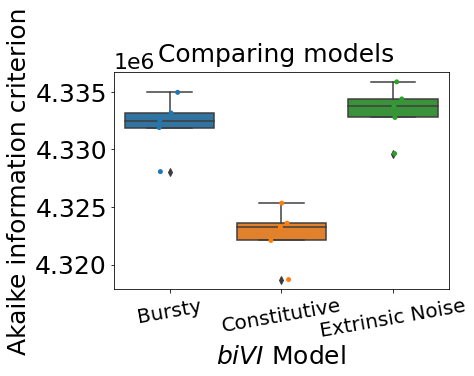

In [110]:
save_path = None
fs = 25


ax = sns.boxplot(data=df_plot, x="Model", y="AIC")

sns.stripplot(data=df_plot, x="Model", y="AIC",ax=ax)
plt.xlabel('$biVI$ Model',fontsize=fs)
plt.ylabel('Akaike information criterion',fontsize=fs)
plt.suptitle('Comparing models',fontsize=fs)
# plt.ylim(0.,1)
plt.xticks(fontsize=20,rotation=10)
plt.yticks(fontsize=25)
# plt.ylim(0.25,0.7)

if save_path:
    plt.savefig(save_path,dpi=400,bbox_inches='tight')